In [1]:
import sqlite3 as sql3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [2]:
# connect to the equational logic database
db = sql3.connect('../Data/DB/eqlogic.db')

In [3]:
# load proof attempts data
df = pd.read_sql_query('SELECT thm_id, name, time_cost, max_mem, num_expansions, '
                       'CASE WHEN proof_date IS NULL THEN 0 ELSE 1 END AS is_proven '
                       'FROM proof_attempts NATURAL JOIN search_settings NATURAL OUTER LEFT JOIN proofs', db)

In [4]:
# no longer need this
db.close()

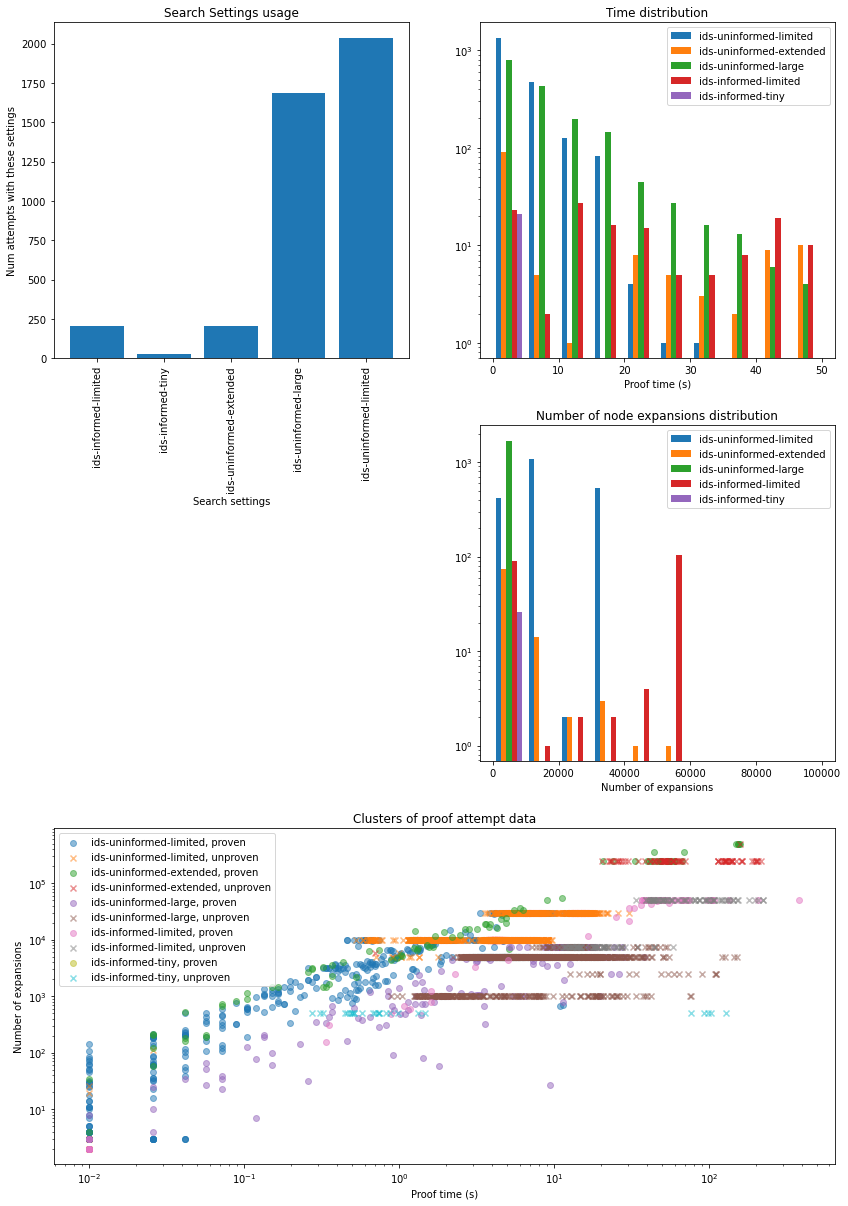

In [5]:
fig = plt.figure(figsize=(14,21))  # figsize in inches

nrows, ncols = 3, 2

# plot bar chart showing how many times each search setting is used
ss_groups = df.groupby('name').count()['thm_id']
ss_usage = plt.subplot(nrows, ncols, 1)
ss_usage.set_title('Search Settings usage')
ss_usage.set_xlabel('Search settings')
ss_usage.set_ylabel('Num attempts with these settings')
ss_usage.bar(ss_groups.keys(), ss_groups)
plt.xticks(rotation='vertical')

# plot histogram showing the distribution of proof times
# for each search settings type
time_graph = plt.subplot(nrows, ncols, 2)
time_graph.set_title('Time distribution')
time_graph.set_xlabel('Proof time (s)')
ss_names, ss_times = pd.unique(df['name']), []
for ss_name in ss_names:
    ss_rows = df[df['name'] == ss_name]
    ss_times.append(ss_rows['time_cost'])
time_graph.hist(ss_times, label=ss_names, bins=10, range=(0.0, 50.0))
time_graph.legend(loc='upper right')
time_graph.set_yscale('log')

# plot histogram showing the distribution of the number of
# node expansions for each search settings type
exp_graph = plt.subplot(nrows, ncols, 4)
exp_graph.set_title('Number of node expansions distribution')
exp_graph.set_xlabel('Number of expansions')
ss_exps = []
for ss_name in ss_names:
    ss_rows = df[df['name'] == ss_name]
    ss_exps.append(ss_rows['num_expansions'])
exp_graph.hist(ss_exps, label=ss_names, bins=10, range=(0,100000))
exp_graph.legend(loc='upper right')
exp_graph.set_yscale('log')

proven_graph = plt.subplot(nrows, 1, 3)
proven_graph.set_title('Clusters of proof attempt data')
proven_graph.set_xlabel('Proof time (s)')
proven_graph.set_ylabel('Number of expansions')
for ss_name in ss_names:
    ss_rows = df[df['name'] == ss_name]
    ss_proven = ss_rows[ss_rows['is_proven'] == 1]
    ss_unproven = ss_rows[ss_rows['is_proven'] == 0]
    plt.scatter(1.0e-2 + ss_proven['time_cost'], 1 + ss_proven['num_expansions'],
               label=ss_name + ', proven', alpha=0.5, marker='o')
    plt.scatter(1.0e-2 + ss_unproven['time_cost'], 1 + ss_unproven['num_expansions'],
               label=ss_name + ', unproven', alpha=0.5, marker='x')
proven_graph.legend(loc='upper left')
proven_graph.set_xscale('log')
proven_graph.set_yscale('log')

plt.show()